# Spatial Stochastic Simulation with SpatialPy
***
Here we illustrate how to implement the model describet in [Sturrock M, Hellander A, Matzavinos A, Chaplain MAJ. 2013 Spatial stochastic modelling of the Hes1 gene regulatory network: intrinsic noise can explain heterogeneity in embryonic stem cell differentiation. J R Soc Interface 10:20120988]
***
## Setup the Environment
***

In [1]:
import os
import sys
sys.path.insert(1, os.path.abspath(os.path.join(os.getcwd(), '../')))

In [2]:
import numpy

MatPlotLib is used for creating custom visualizations

In [3]:
import matplotlib.pyplot as plt

In [4]:
import spatialpy

***
## Create Geometries for the Domain
***

In [5]:
class Nucleus(spatialpy.Geometry):
    def inside(self, point, on_boundary):
        return point[0]**2 + point[1]**2 + point[2]**2 <= 3**2

In [6]:
class Cytoplasm(spatialpy.Geometry):
    def inside(self, point, on_boundary):
        return point[0]**2 + point[1]**2 + point[2]**2 > 3**2

***
## Create Hes1 Model
***

In [7]:
def create_hes1(model_name="hes1", parameter_values=None):
    # Initialize Model
    model = spatialpy.Model(model_name)

    # Define Domain Type IDs as constants of the Model
    model.NUCLEUS = Nucleus.__name__
    model.CYTOPLASM = Cytoplasm.__name__
    
    # System constants
    D_P = 1e-12
    D_mRNA = 1e-12
    
    # Define Domain
    domain = spatialpy.Domain.read_xml_mesh("Domain_Files/GRN_Spatial.mesh.xml")
    
    # # Add Type IDs to the Particles
    domain.read_stochss_subdomain_file(
        "Domain_Files/GRN_Spatial.subdomains.txt", type_ids={"1": model.NUCLEUS, "2": model.CYTOPLASM}
    )
    
    # Set Model Domain
    model.add_domain(domain)

    # Define Variables (SpatialPy.Species)
    G_f = spatialpy.Species(name='G_f', diffusion_coefficient=0.0)
    G_o = spatialpy.Species(name='G_o', diffusion_coefficient=0.0)
    mRNA = spatialpy.Species(name='mRNA',diffusion_coefficient=D_mRNA)
    P = spatialpy.Species(name='P', diffusion_coefficient=D_P)
    
    # Add Variables to Model
    model.add_species([G_f, G_o, mRNA, P])

    # Define Parameters
    mu = spatialpy.Parameter(name='mu', expression=0.002)
    kappa = spatialpy.Parameter(name='kappa', expression=0.015)
    ka = spatialpy.Parameter(name='ka', expression=1.6605778811e-20)
    kd = spatialpy.Parameter(name='kd', expression=0.01)
    gamma_m = spatialpy.Parameter(name='gamma_m', expression=6e-4)
    gamma_p = spatialpy.Parameter(name='gamma_p', expression=3e-4)
    
    # Add Parameters to Model
    model.add_parameter([mu, kappa, ka, kd, gamma_m, gamma_p])

    # Define Reactions
    rxn1 = spatialpy.Reaction(name='R1', reactants={'G_f': 1, 'P': 1}, products={'G_o': 1}, rate='ka')
    rxn2 = spatialpy.Reaction(
        name='R2', reactants={'mRNA': 1}, products={'mRNA': 1, 'P': 1}, rate='kappa', restrict_to=model.CYTOPLASM
    )
    rxn3 = spatialpy.Reaction(name='R3', reactants={'G_f': 1}, products={'G_f': 1, 'mRNA': 1}, rate='mu')
    rxn4 = spatialpy.Reaction(name='R4', reactants={'mRNA': 1}, products={}, rate='gamma_m')
    rxn5 = spatialpy.Reaction(name='R5', reactants={'P': 1}, products={}, rate='gamma_p')
    rxn6 = spatialpy.Reaction(name='R6', reactants={'G_o': 1}, products={'G_f': 1, 'P': 1}, rate='kd')
    
    # Add Reactions to Model
    model.add_reaction([rxn1, rxn2, rxn3, rxn4, rxn5, rxn6])

    # Define Initial Conditions
    G_f_ic = spatialpy.PlaceInitialCondition(G_f, 1, location=[0,0,0])
    
    # Add Initial Conditions to Model
    model.add_initial_condition(G_f_ic)

    # Define Timespan
    tspan = spatialpy.TimeSpan.linspace(t=24 * 3600, num_points=2000, timestep_size=1)
    
    # Set Model Timespan
    model.timespan(tspan)
    return model

### Instantiate the Model

In [8]:
model = create_hes1()

### Instantiate the Solver

In [9]:
sol = spatialpy.Solver(model, debug_level=0)
%time sol.compile()
print(sol.build_dir)

CPU times: user 28.1 ms, sys: 9.34 ms, total: 37.4 ms
Wall time: 1.31 s
/var/folders/z4/bqpnd_kx7xg3s3c9jtz0pnfh0000gn/T/spatialpy_build_lmrn5sc0


***
## Run the Simulation
***

In [10]:
%time result = sol.run()

CPU times: user 11.2 ms, sys: 10.1 ms, total: 21.2 ms
Wall time: 14min 57s


***
## Visualizations
***
### Plot the evolution of the copy number of a given species

In [11]:
def plot_hes1(result):
    protein = result.get_species("P")
    proteinsum = numpy.sum(protein, axis=1)
    plt.plot(numpy.array(result.tspan) / 3600, proteinsum, 'r', label='protein')
    
    mRNA = result.get_species("mRNA")
    mRNAsum = numpy.sum(mRNA[:], axis=1)
    plt.plot(numpy.array(result.tspan) / 3600, mRNAsum, 'b', label='mRNA')
    
    plt.legend(loc='best')
    plt.xlabel('time (h)')
    plt.ylabel('# of molecules')

CPU times: user 18.7 s, sys: 618 ms, total: 19.3 s
Wall time: 20.8 s


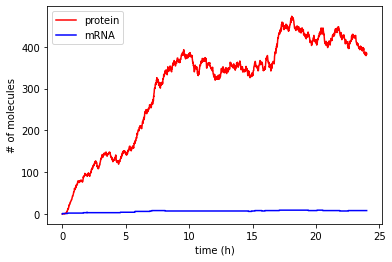

In [12]:
%time plot_hes1(result)

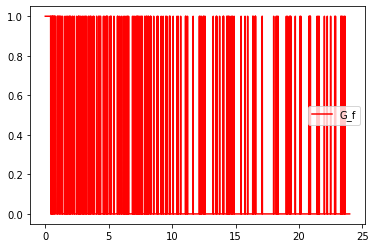

In [13]:
pf = numpy.sum(result.get_species("G_f"), axis=1)
plt.plot(numpy.array(result.tspan) / 3600, pf, 'r', label="G_f")
plt.legend(loc="best")